---
这一节几乎都是第一版的内容

---

## 12.4 变分自编码生成图像

今天,创造性人工智能最流行的应用是图像生成: 神经网络学习潜在的视觉空间,从中取样生成全新的图片.一些应用就包括了人脸的生成.

在这一小节和下一小节,我们会回顾与图像生成有关的高级概念,以及整个领域两种技术的细节: 变分自动编码器(VAEs) 和生成对抗网络(GANs),这里所提及的技术并不仅针对图像,声音/文本/音乐等等,都有潜在的空间.但是在实践中,最有趣的结果是在图片获得的.


## 从潜在空间中取样

图像生成的关键思想是找到一个低维表示的潜在空间,其中任意点都可以被映射为一张逼真的图片.能够完成这样映射的模块叫做生成器(对GAN) 或 解码器(对VAE).一旦完成了这个映射,就可以从中随意的进行采用,将其映射到图像空间,生成前所未见的新图像.

![image_generation](image_generation.png)


寻找这样的潜在空间,GAN 和 VAE 是两种完全不同的策略,两种策略各有特点.VAE 非常适合学习具有良好结构的潜在空间,其中特定方向表示数据中有意义的变化轴.GAN 生成的图像可能非常逼真,但是其潜在空间可能并不具有良好的结构,也没有足够的连续性.

![A-continuous-space-of-faces-generated-by-Tom-White-using-VAEs](A-continuous-space-of-faces-generated-by-Tom-White-using-VAEs.png)


## 图像编辑的概念向量

在第 11 章讨论到词嵌入时,就已经在提到了和 概念向量(概念向量) 相似的思想.给定一个表示的潜在空间或者嵌入空间,空间中特定方向可能表示原始数据中的有趣变化.例如人脸的图像潜在空间,就可能存在一个微笑向量s: 如果潜在的点 z 是某张人脸的嵌入表示,那么 z+s 就是同一张脸微笑的样子.

从样本图像构造潜在空间,输入图片,找到其在潜在空间的表示,然后以一种有意义的移动.最好将其解码到图像空间.在人脸空间我们会发现一些非常有趣的概念向量: 给人脸增加墨镜/去掉墨镜的概念向量,将男性面孔变为女性面孔的向量...

![The-smile-vector](The-smile-vector.png)

## 变分自编码器

自编码器由 Kingma 和 Welling 于 2013 年 12 月与 Rezende、Mohamed 和 Wierstra 于 2014 年 1 月同时发现,它是一种生成式模型,特别适用于利用概念向量进行图像编辑的任务.它是一种现代化的自编码器,将深度学习的想法与贝叶斯推断结合在一起.自编码器是一种网络类型,其目的是将输入编码到低维潜在空间,然后再解码回来.

经典的图像自编码器接收一张图像,通过一个编码器模块将其映射到潜在向量空间,然后再通过一个解码器模块将其解码为与原始图像具有相同尺寸的输出（见图8-12）.然后,使用与输入图像相同的图像作为目标数据来训练这个自编码器,也就是说,自编码器学习对原始输入进行重新构建.通过对代码（编码器的输出）施加各种限制,我们可以让自编码器学到比较有趣的数据潜在表示.最常见的情况是将代码限制为低维的并且是稀疏的（即大部分元素为0）,在这种情况下,编码器的作用是将输入数据压缩为更少二进制位的信息.

![autoencoder](autoencoder.png)


实践中证明经典的自编码器并不能得到特别好用或者有良好结构的潜在空间,自编码器也没有对数据有多少的压缩,在现在它们早就过时了.但是 VAE 向自编码器添加了一点统计学的能源催化剂.使其能够学习连续的高度结构化的潜在空间,这使得 VAE 成为强大的图像处理工具.

VAE 并不是将输入图像压缩成潜在空间的额 固定编码,而是将图像转换成统计分布的参数,即平均值和方差.本质上这意味着我们假设输入图像是由统计过程生成的,在编码和解码过程中应该考虑这一过程的随机性.然后 VAE 使用平均值和方差两个参数从分布中采样一个元素,并将这个元素解码到原始输入.这个过程的随机性提高了其健壮性,并迫使潜在空间的任何位置都有其对应的有意义的显示,即潜在空间的任何一点都可以解码为有效输出.

![vae](vae.png)


技术角度来说,VAE 的工作原理如下

- 一个编码器将输入样本 `input_img` 转化为潜在空间的两个参数  `z_mean` 和 `z_log_variance`.
- 我们假定潜在的正态分布能够生成图像,从这个分布中随机采样一个点 z: `z = z_mean + exp(z_log_variance) * epsilon.` 其中 epsilon 是取值很小的随机变量.
- 解码器模块将潜在空间的这个点映射回原始输入图像.

因为 epsilon 是随机的所以这个过程可以确保与 `input_img` 编码的潜在位置靠近的每个点都能被编码为与 `input_img` 类似的图像,从而迫使潜在空间具有连续的意义.

这样构造的潜在空间任意两个相邻的点都会被解码为高度相似的图像,连续性及潜在空间的低维度,使得潜在空间的任何一个方向都成为表示数据中有意义的一个轴,这使得潜在空间具有良好的结构,非常适合通过概念向量操作.

VAE 的参数通过两个损失函数进行训练:

- 重构损失: 迫使解码后的样本匹配初始输入.
- 正则化损失: 有助于学习到良好结构的潜在空间,降低过拟合.

大致的伪代码:

```py
z_mean, z_log_variance = encoder(input_img)
z = z_mean + exp(z_log_variance) * epsilon
reconstructed_img = decoder(z)
model = Model(input_img, reconstructed_img)
```

之后就可以使用 重构损失 和 正则化损失 来训练模型了.特别的对于正则化损失,我们通常使用 Kullback–Leibler divergence 表示.旨在将编码器输出分布推到以 0 为中心的标准正态分布.这为编码器提供了一个关于其建模的潜在空间结构的合理假设.


## keras 实现 VAE

主要有 3 个部分:

- 编码器网络,将真实图像转化为潜在空间的平均值和方差
- 取样层,随机取一个平均值和方差,使用它们从潜在空间随机取样一个点.
- 解码器网络,将随机点映射回图像.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2  #潜在空间的维度

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2,
                  padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [3]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

编码器网络,将图像映射到潜在空间.这里是一个简单的 cnn ,将输入图像 x 映射到两个向量,`z_mean` 和 `z_log_var`.

这里使用的是步长对特征图下采样,而不是最大池化.对于任何关心位置信息的模型,步长总是比最大池化更好.


In [4]:
import tensorflow as tf


class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))  #一匹随机的正态向量
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon  # 应用 VAE 的抽样公式


In [ ]:
Sampler 是使用 z_mean 和 z_log_var 产生潜在点 z 的类.

In [5]:
latent_inputs = keras.Input(shape=(latent_dim, ))  #输入 z
x = layers.Dense(7 * 7 * 64,
                 activation="relu")(latent_inputs)  #产生于编码器 Flatten 相同的系数
x = layers.Reshape((7, 7, 64))(x)  #还原 Flatten
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2,
                           padding="same")(x)  #逆转 cnn 层
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2,
                           padding="same")(x)  #逆转 cnn 层
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid",
                                padding="same")(x)  #最终的形状是 (28, 28, 1)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [6]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

解码器的实现,将向量 z 转化为图像.使用了几个卷积层,最终的输出尺寸和原始输入图像相同.


In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(
            name="total_loss")  # 这 3 个指标跟踪模型的损失
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):  #返回指标,这些指标会在每个迭代后重置
        return [
            self.total_loss_tracker, self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.binary_crossentropy(
                    data, reconstruction),
                              axis=(1, 2)))  # 对空间维度 1 2 的重建损失求和,再平均
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))  #正则化项
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

VAE 可能是这本书上第一个无监督学习模型的例子(自动编码器使用输入作为目标).每当使用非经典的监督学习时,最好是对模型进行子类化,并实现一个自定义的 `train_step`.


In [10]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 15s 22ms/step - total_loss: 210.2680 - reconstruction_loss: 207.6585 - kl_loss: 2.6090
Epoch 2/30
547/547 [==============================] - 12s 22ms/step - total_loss: 170.6764 - reconstruction_loss: 166.6733 - kl_loss: 4.0032
Epoch 3/30
547/547 [==============================] - 11s 20ms/step - total_loss: 162.6281 - reconstruction_loss: 158.8562 - kl_loss: 3.7717
Epoch 4/30
547/547 [==============================] - 12s 22ms/step - total_loss: 158.6385 - reconstruction_loss: 154.8051 - kl_loss: 3.8333
Epoch 5/30
547/547 [==============================] - 10s 19ms/step - total_loss: 156.1776 - reconstruction_loss: 152.3284 - kl_loss: 3.8491
Epoch 6/30
547/547 [==============================] - 11s 19ms/step - total_loss: 154.3425 - reconstruction_loss: 150.4732 - kl_loss: 3.8693
Epoch 7/30
547/547 [==============================] - 11s 20ms/step - total_loss: 153.0990 - reconstruction_loss: 149.2222 - kl_loss: 3.8768
Epoch 8/30
54

这里就可以开始训练了,在 mnist 数据集上.

因为损失是在自定义层处理的,所以是 `loss=None`

同时是无监督学习,训练时并不会传递目标数据.所以只有 `x_train`

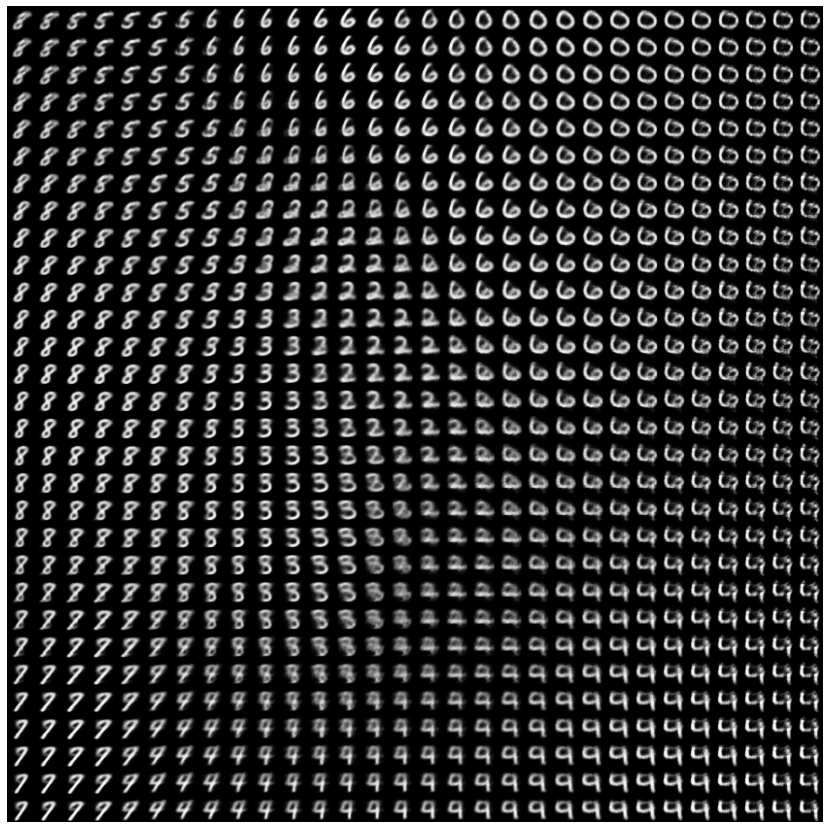

In [11]:
import matplotlib.pyplot as plt

n = 30  # 30x30 个数字
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]  # 二维网格上线性取点

for i, yi in enumerate(grid_y):  #网格上迭代
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])  #抽样数字
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size:(i + 1) * digit_size,
               j * digit_size:(j + 1) * digit_size, ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

30x30 共 900 个数字,当沿着特定方向前进时,数字的变化是有意义的(概念向量)


## 收尾

再来回顾一下 VAE 和 GAN:

- VAE 可以产生高度结构化连续的潜在空间
- GAN 则能生成足够逼真的单帧图像.

大部分成功的应用都有赖于 VAE,但是 GAN 确实最有人气的那一个.
